### Import required modules
Dataset: https://www.kaggle.com/datasets/mattop/panda-or-bear-image-classification?select=PandasBears    
References: Deep Learning with Python 2nd Edition  

In [1]:
import os
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np

import matplotlib.pyplot as plt

### Define path to training data
Since we don't need to evaulate our model, We don't need validation or test data

In [2]:
data_dir = 'PandasBears'
train_dir = os.path.join(data_dir, 'Train')

### Use built-in ImageDataGenerators feed the model with data

In [3]:
# Normalize data - Map RGB values into [0, 1] range
train_datagen = ImageDataGenerator(rescale=1./255)

# Each image in the data set is 256x256 
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(256, 256), 
    batch_size=10, 
    class_mode='binary')


Found 500 images belonging to 2 classes.


### Define a simple CNN model for classify images
Each Conv2D layer has multiple filters. Once the training process is completed, we can see what those filters do

In [4]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(256, 256, 3)))  # We will use this first layer to visualize CNN
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)      0

### Train the model using generator we created

In [12]:
history = model.fit(train_generator,  steps_per_epoch=25, epochs=10)

Epoch 1/10
25/25 [==============================] - 1s 37ms/step - loss: 3.4603e-05 - acc: 1.0000
Epoch 2/10
25/25 [==============================] - 1s 36ms/step - loss: 7.3914e-06 - acc: 1.0000
Epoch 3/10
25/25 [==============================] - 1s 36ms/step - loss: 7.3160e-08 - acc: 1.0000
Epoch 4/10
25/25 [==============================] - 1s 36ms/step - loss: 0.8436 - acc: 0.9680
Epoch 5/10
25/25 [==============================] - 1s 36ms/step - loss: 4.9445e-04 - acc: 1.0000
Epoch 6/10
25/25 [==============================] - 1s 36ms/step - loss: 0.5784 - acc: 0.9760
Epoch 7/10
25/25 [==============================] - 1s 36ms/step - loss: 1.4315e-04 - acc: 1.0000
Epoch 8/10
25/25 [==============================] - 1s 36ms/step - loss: 1.1741e-05 - acc: 1.0000
Epoch 9/10
25/25 [==============================] - 1s 36ms/step - loss: 2.6244e-06 - acc: 1.0000
Epoch 10/10
25/25 [==============================] - 1s 36ms/step - loss: 0.2913 - acc: 0.9600


### Select an image to visualize what filters do 
Load an image into a numpy array and normalize it

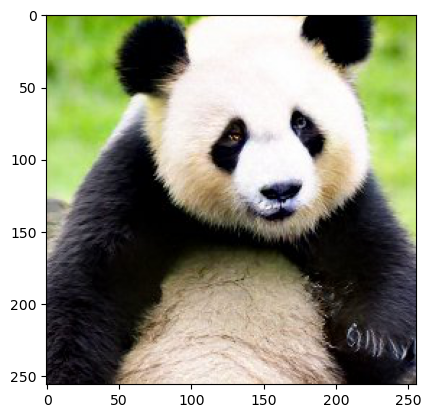

In [6]:
test_img_path = './PandasBears/Test/Pandas/251.jpeg'


img = load_img(test_img_path, target_size=(256, 256))
img_tensor = img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)  # Because we need a batch of images - We a batch of 1 image
img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.show()


### Extract a trained convolution layer from the model

We can list down the layers in the model like this

In [13]:
for layer in model.layers:
    print(layer.name)

conv2d
max_pooling2d
conv2d_1
max_pooling2d_1
conv2d_2
max_pooling2d_2
conv2d_3
max_pooling2d_3
conv2d_4
max_pooling2d_4
flatten
dense
dense_1


We create a new model - This model's input tensor is the our original model's input tensor. Output is same as first conv2D layer's output 

In [14]:
print("Model input shape: ", model.input.shape)
print("Model ouput shape: ", model.output.shape)

Model input shape:  (None, 256, 256, 3)
Model ouput shape:  (None, 1)


In [15]:
layer = model.layers[0]

print("Conv2d input shape: ", model.layers[0].input.shape)
print("Conv2d output shape: ", model.layers[0].output.shape)

filter_model = models.Model(model.inputs, layer.output) # We are taking the input of the our model and the outputs of the convolutions/pooling layers of our model
# When feed an image input, this model returns 32 images that have been filtered by different filters

print("Filter model input shape: ", filter_model.input.shape)
print("Filter model output shape: ", filter_model.output.shape)

Conv2d input shape:  (None, 256, 256, 3)
Conv2d output shape:  (None, 254, 254, 32)
Filter model input shape:  (None, 256, 256, 3)
Filter model output shape:  (None, 254, 254, 32)


Note that sizes of the output images are 254x254 because of the border effect from (3, 3) filters

### Send image thought the first layer (32 filters)

In [16]:
outputs = filter_model.predict(img_tensor)
print(outputs.shape)  # Output shape of this will be similar to the output shape of the first layer in the actual model (check model.summary())

1/1 [==============================] - 0s 42ms/step
(1, 254, 254, 32)


### Plot output values

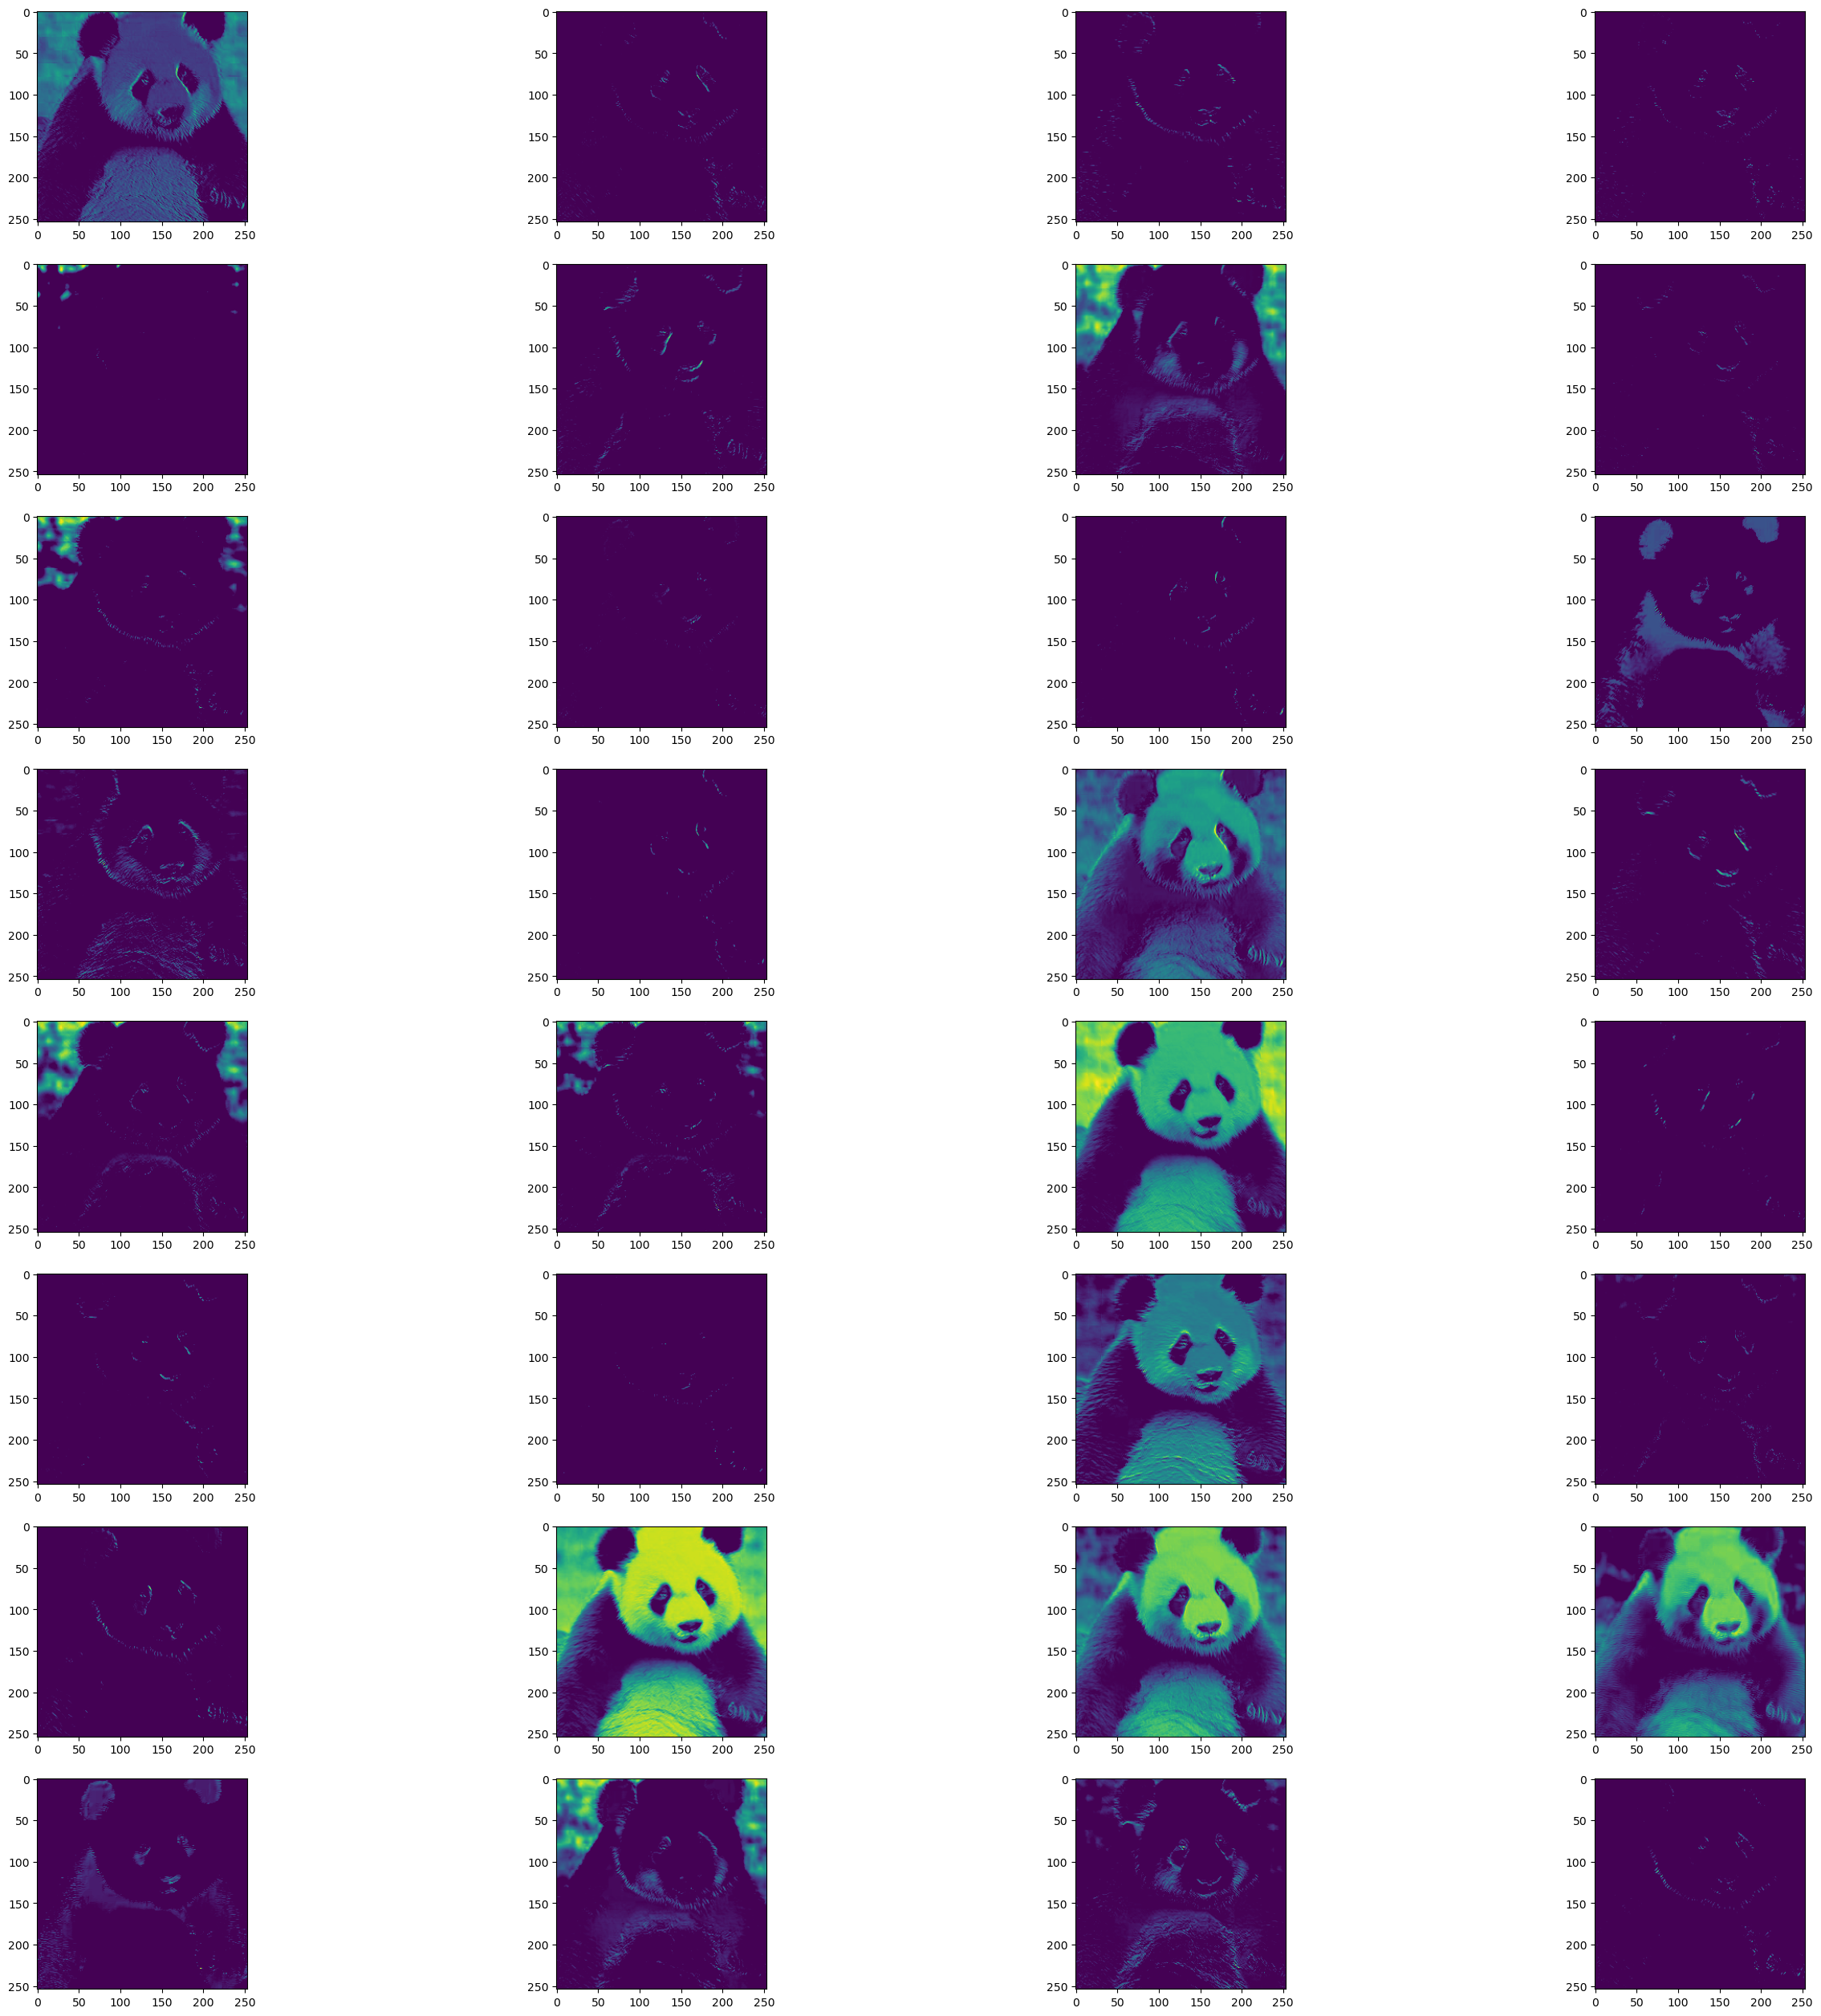

In [17]:
# Lets plot this

output_filters = [outputs[0, :, :, i] for i in range(32)]
fig = plt.figure(figsize=(32, 32))
rows = 8
cols = 4
i = 1

for output_filter in output_filters:
    fig.add_subplot(rows, cols, i)
    plt.imshow(output_filter)
    i += 1
plt.show()